In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from typing import List
import time

sys.path.append("../")

from RGS import FastRandomizedGreedySelection, RandomizedGreedySelection
from data_generator import *

In [2]:
def calculate_df(y, y_true, y_pred, n, sigma):
    """Calculate degrees of freedom using the provided formula."""
    train_error = np.mean((y - y_pred)**2)
    insample_error = np.mean((y_true - y_pred)**2)
    df = n/(2*sigma**2) * (insample_error - train_error + sigma**2)
    return df

In [3]:
def compute_penalty(m: int, omega: List[float], sigma2: float, n: int) -> float:
    """Compute the penalty term for feature selection using sorted coefficients."""
    omega_sorted = sorted(omega, reverse=True)
    return (2 * sigma2**2 / n) * sum(np.log(p / (j+1)) * omega_sorted[j] for j in range(p))

In [4]:
def compute_penalized_score(model, X, y_true, k, sigma2, n, p):
    """
    Compute penalized score using MSE + penalty.
    
    Parameters
    ----------
    model : RGS/FGS model
        Fitted model with .coef_ attribute
    X : ndarray
        Input design matrix
    y_true : ndarray
        True signal (without noise)
    k : int
        Number of features to use
    sigma2 : float
        True noise variance
    n : int
        Sample size
    p : int
        Number of features
        
    Returns
    -------
    float
        Penalized score (MSE + penalty)
    """
    # Get predictions and MSE
    y_pred = model.predict(X, k=k)
    mse = mean_squared_error(y_true, y_pred)
    
#     # Get coefficients and sort them by absolute value
#     coef = np.abs(model.coef_)  # Get absolute values
#     coef_sorted = np.sort(coef)[::-1]  # Sort in descending order
    
#     # Use top k coefficients
#     coef_k = coef_sorted[:k]
    
    # Compute penalty
    penalty = 2*sigma2**2/n*k*np.log(p/k)
    
    return mse + penalty

In [13]:
def run_simulation(n_predictors=250, n_train=2000, signal_proportion=0.04, cov='orthogonal', n_sim=10):
    """
    Run simulation comparing different methods, varying k_max during training.
    """
    
    # Start timing
    start_time = time.time()
    
    # Generate base design matrix
    X_generators = {
        'orthogonal': generate_orthogonal_X,
        'banded': generate_banded_X
    }
    if isinstance(cov, str):
        if cov not in X_generators:
            raise ValueError(f"Unknown generator: {cov}. Available generators: {list(X_generators.keys())}")
        X_generator = X_generators[cov]
    else:
        # Assume it's a callable
        X_generator = cov
    X = X_generator(n_predictors, n_train)
    
    # Define k values for training and m values for RGS
    k_values = list(range(2, 19, 4))  # [5, 10, 15, ..., 50]
    base = 2
    num_points = 7
    m_values = [int(2 + (n_predictors-2) * (base**x - 1)/(base**(num_points-1) - 1)) 
            for x in range(num_points)]
    
    # Initialize results storage
    results = []
    
    # Define example generators with different noise levels
    sigmas = [25, 30, 35, 40, 45]
    example_generators = {
        f'sigma_{sigmas[0]}': generate_exact_sparsity_example,
        f'sigma_{sigmas[1]}': generate_exact_sparsity_example,
        f'sigma_{sigmas[2]}': generate_exact_sparsity_example,
        f'sigma_{sigmas[3]}': generate_exact_sparsity_example,
        f'sigma_{sigmas[4]}': generate_exact_sparsity_example
#         'sigma_10_linear': generate_nonlinear_example,
#         'sigma_10_highly_nonlinear': generate_nonlinear_example,
#         'sigma_60_small_snr': generate_small_snr,
#         'sigma_15_laplace': generate_laplace_example,
#         'sigma_15_cauchy': generate_cauchy_example
    }
    
    # Create progress bar for total iterations
    total_iterations = n_sim * len(example_generators)
    pbar = tqdm(total=total_iterations, desc="Overall Progress")
    
    # Time the first iteration separately to get a good estimate
    first_iter_time = None
    
    for sim in range(n_sim):
        i = 0
        for noise_level, generator in example_generators.items():
            iter_start_time = time.time()
            # Generate data for this simulation
#             if (noise_level == 'sigma_10_linear'):
#                 flag = 0
#             else:
#                 flag = 1
#             X, y, y_true, p, sigma = generator(X, seed=sim, eta=flag)
            X, y, y_true, beta_true, p, sigma = generator(X, signal_proportion, sigmas[i], seed=sim)
            
            result = {
                'simulation': sim,
                'noise_level': noise_level,
                'sigma': sigma
            }
            
            # Fit Lasso
            lasso = LassoCV(cv=10, random_state=sim)
            lasso.fit(X, y)
            y_pred_lasso = lasso.predict(X)
            result['mse_lasso'] = mean_squared_error(y_true, y_pred_lasso)
            result['df_lasso'] = calculate_df(y, y_true, y_pred_lasso, n_train, sigma)
            result['coef_recovery_lasso'] = np.mean((lasso.coef_ - beta_true)**2)
            result['support_recovery_lasso'] = np.mean((lasso.coef_ != 0) == (beta_true != 0))
            
            # Fit Ridge
            ridge = RidgeCV(cv=10)
            ridge.fit(X, y)
            y_pred_ridge = ridge.predict(X)
            result['mse_ridge'] = mean_squared_error(y_true, y_pred_ridge)
            result['df_ridge'] = calculate_df(y, y_true, y_pred_ridge, n_train, sigma)
            result['coef_recovery_ridge'] = np.mean((ridge.coef_ - beta_true)**2)
            
            # Fit Elastic Net
            elastic = ElasticNetCV(cv=10, random_state=sim)
            elastic.fit(X, y)
            y_pred_elastic = elastic.predict(X)
            result['mse_elastic'] = mean_squared_error(y_true, y_pred_elastic)
            result['df_elastic'] = calculate_df(y, y_true, y_pred_elastic, n_train, sigma)
            result['coef_recovery_elastic'] = np.mean((elastic.coef_ - beta_true)**2)
            result['support_recovery_elastic'] = np.mean((elastic.coef_ != 0) == (beta_true != 0))
            
            # Fit FGS
            mse_fgs = {}
            for k_max in k_values:
                fgs = FastRandomizedGreedySelection(k_max=k_max, m=n_predictors, n_resample_iter=7)
                fgs.fit(X, y)
                y_pred_fgs = fgs.predict(X, k=k_max)
                result[f'mse_fgs_k{k_max}'] = mean_squared_error(y_true, y_pred_fgs)
                result[f'df_fgs_k{k_max}'] = calculate_df(y, y_true, y_pred_fgs, n_train, sigma)
                result[f'pen_fgs_k{k_max}'] = compute_penalized_score(fgs, X, y_true, k_max, sigma, n_train, p)
                result[f'coef_recovery_fgs_k{k_max}'] = np.mean((fgs.coef_ - beta_true)**2)
                result[f'support_recovery_fgs_k{k_max}'] = np.mean((fgs.coef_ != 0) == (beta_true != 0))
            
            # Fit RGS
            mse_rgs = {}
            for m in m_values:
                for k_max in k_values:
                    rgs = FastRandomizedGreedySelection(k_max=k_max, m=m, n_resample_iter=7)
                    rgs.fit(X, y)
                    y_pred_rgs = rgs.predict(X, k=k_max)
                    result[f'mse_rgs_m{m}_k{k_max}'] = mean_squared_error(y_true, y_pred_rgs)
                    result[f'df_rgs_m{m}_k{k_max}'] = calculate_df(y, y_true, y_pred_rgs, n_train, sigma)
                    result[f'pen_rgs_m{m}_k{k_max}'] = compute_penalized_score(rgs, X, y_true, k_max, sigma, n_train, p)
                    result[f'coef_recovery_rgs_m{m}_k{k_max}'] = np.mean((rgs.coef_ - beta_true)**2)
                    result[f'support_recovery_rgs_m{m}_k{k_max}'] = np.mean((rgs.coef_ != 0) == (beta_true != 0))
            
            results.append(result)
            
            # Calculate timing information
            iter_time = time.time() - iter_start_time
            if first_iter_time is None:
                first_iter_time = iter_time
                estimated_total_time = first_iter_time * total_iterations
            
            iterations_completed = sim * len(example_generators) + list(example_generators.keys()).index(noise_level) + 1
            time_elapsed = time.time() - start_time
            time_per_iter = time_elapsed / iterations_completed
            estimated_remaining_time = time_per_iter * (total_iterations - iterations_completed)
            
            # Update progress bar with timing information
            pbar.set_postfix({
                'Simulation': f'{sim + 1}/{n_sim}',
                'Noise': noise_level,
                'Iter Time': f'{iter_time:.1f}s',
                'Est. Remaining': f'{estimated_remaining_time/60:.1f}min',
                'Est. Total': f'{(time_elapsed + estimated_remaining_time)/60:.1f}min'
            })
            pbar.update(1)
            
            i += 1
            
    # Close progress bar
    pbar.close()
    total_time = time.time() - start_time
    print(f"\nSimulation completed in {total_time/60:.1f} minutes")
    print(f"Average time per iteration: {total_time/total_iterations:.1f} seconds")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics for both MSE and DF
    metrics = ['mse', 'df']
    base_methods = ['lasso', 'ridge', 'elastic']
    agg_cols = {}
    
    # Add base methods
    for metric in metrics:
        for method in base_methods:
            col = f'{metric}_{method}'
            agg_cols[col] = ['mean', 'std']
    
    # Add FGS methods
    for metric in metrics:
        for k in k_values:
            col = f'{metric}_fgs_k{k}'
            agg_cols[col] = ['mean', 'std']
    
    # Add RGS methods
    for metric in metrics:
        for m in m_values:
            for k in k_values:
                col = f'{metric}_rgs_m{m}_k{k}'
                agg_cols[col] = ['mean', 'std']
    
    summary = results_df.groupby('noise_level').agg(agg_cols).round(4)
    
    # Save results with timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f'../data/simulation_results_{timestamp}.csv', index=False)
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary.to_csv(f'../data/simulation_summary_{timestamp}.csv')
    
    print(f"\nResults saved to simulation_results_{timestamp}.csv")
    print(f"Summary saved to simulation_summary_{timestamp}.csv")
    
    return results_df, summary

In [7]:
def analyze_optimal_parameters(results_df):
    """
    Analyze the results to find optimal k and m values for each noise level.
    Also includes degrees of freedom analysis.
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from run_simulation
        
    Returns:
    --------
    DataFrame with optimal parameters and corresponding MSE and DF values
    """
    noise_levels = sorted(results_df['noise_level'].unique())
    optimal_params = []
    
    for noise in noise_levels:
        noise_data = results_df[results_df['noise_level'] == noise]
        
        # Find best FGS k value based on penalized
        fgs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_fgs_k')]
        best_fgs_col = min(fgs_mse_cols, key=lambda x: noise_data[x].mean())
        best_fgs_k = int(best_fgs_col.replace('pen_fgs_k', ''))
        best_fgs_mse = noise_data[f'mse_fgs_k{best_fgs_k}'].mean()
        best_fgs_df = noise_data[f'df_fgs_k{best_fgs_k}'].mean()
        
        # Find best RGS m and k values based on penalized
        rgs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_rgs_m')]
        best_rgs_col = min(rgs_mse_cols, key=lambda x: noise_data[x].mean())
        # Extract m and k values using string replacement
        col_parts = best_rgs_col.replace('pen_rgs_m', '').split('_k')
        m_val = int(col_parts[0])
        k_val = int(col_parts[1])
        best_rgs_mse = noise_data[f'mse_rgs_m{m_val}_k{k_val}'].mean()
        best_rgs_df = noise_data[f'df_rgs_m{m_val}_k{k_val}'].mean()
        
        # Get baseline methods performance
        baseline_metrics = {
            'lasso_mse': noise_data['mse_lasso'].mean(),
            'lasso_df': noise_data['df_lasso'].mean(),
            'ridge_mse': noise_data['mse_ridge'].mean(),
            'ridge_df': noise_data['df_ridge'].mean(),
            'elastic_mse': noise_data['mse_elastic'].mean(),
            'elastic_df': noise_data['df_elastic'].mean()
        }
        
        # Store results
        optimal_params.append({
            'noise_level': noise,
            'sigma': noise_data['sigma'].iloc[0],
            'fgs_k': best_fgs_k,
            'fgs_mse': best_fgs_mse,
            'fgs_df': best_fgs_df,
            'rgs_m': m_val,
            'rgs_k': k_val,
            'rgs_mse': best_rgs_mse,
            'rgs_df': best_rgs_df,
            **baseline_metrics
        })
    
    return pd.DataFrame(optimal_params)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_k_value(col_name):
    """Safely extract k value from column name."""
    try:
        parts = col_name.split('_k')
        if len(parts) > 1:
            return int(parts[1].split('_')[0])
    except:
        return None

def get_m_value(col_name):
    """Safely extract m value from column name."""
    try:
        parts = col_name.split('_m')
        if len(parts) > 1:
            return int(parts[1].split('_')[0])
    except:
        return None

def find_best_methods(data, metric_prefix='pen'):
    """Find best performing FGS and RGS methods based on mean penalized."""
    # Find best FGS
    fgs_cols = [col for col in data.columns if col.startswith(f'{metric_prefix}_fgs_k')]
    best_fgs_col = min(fgs_cols, key=lambda x: data[x].mean())
    
    # Find best RGS
    rgs_cols = [col for col in data.columns if col.startswith(f'{metric_prefix}_rgs_m')]
    best_rgs_col = min(rgs_cols, key=lambda x: data[x].mean())
    
    return best_fgs_col, best_rgs_col

def save_fig(fig, filename, dpi=300):
    """Helper function to save figures with consistent settings."""
    fig.savefig(filename, bbox_inches='tight', dpi=dpi)
    plt.close(fig)

def plot_mse_and_df_comparison(results_df, save=True):
    """
    Create side-by-side boxplots comparing MSE and degrees of freedom across methods and noise levels.
    """
    plt.style.use('seaborn')
    noise_levels = sorted(results_df['noise_level'].unique())
    
    # Create figure with two columns (MSE and DF) and rows for each noise level
    fig, axes = plt.subplots(len(noise_levels), 2, figsize=(20, 6*len(noise_levels)))
    
    # Colors for different method types
    colors = {
        'baseline': 'skyblue',
        'fgs': 'lightgreen',
        'rgs': 'salmon'
    }
    
    for idx, noise in enumerate(noise_levels):
        noise_data = results_df[results_df['noise_level'] == noise]
        
        # Find best methods based on MSE
        best_fgs_col, best_rgs_col = find_best_methods(noise_data)
        
        # Plot MSE (left column)
        ax_mse = axes[idx, 0]
        plot_metric_boxplots(noise_data, 'mse', ax_mse, colors, best_fgs_col, best_rgs_col)
        ax_mse.set_title(f'MSE Distribution (σ = {noise.split("_")[1]})', fontsize=14)
        ax_mse.set_yscale('log')
        
        # Plot corresponding DF (right column)
        ax_df = axes[idx, 1]
        plot_metric_boxplots(noise_data, 'df', ax_df, colors, best_fgs_col, best_rgs_col)
        ax_df.set_title(f'Degrees of Freedom (σ = {noise.split("_")[1]})', fontsize=14)
    
    # Create legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                      for label, color in colors.items()]
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    if save:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_fig(fig, f'../figures/boxplots_comparison_{timestamp}.png')
    
    return fig

def plot_mean_performance(results_df, save=True):
    """Plot mean MSE and DF for each method across different sigma values."""
    plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get sigma values
    sigma_values = sorted(results_df['sigma'].unique())
    
    # Colors and markers for different method types
    styles = {
        'Lasso': ('skyblue', 'o'),
        'Ridge': ('skyblue', 's'),
        'Elastic': ('skyblue', '^'),
        'FGS': ('lightgreen', 'D'),
        'RGS': ('salmon', 'v')
    }
    
    # For each noise level, find best FGS and RGS methods
    mean_values_mse = {method: [] for method in ['Lasso', 'Ridge', 'Elastic', 'FGS', 'RGS']}
    mean_values_df = {method: [] for method in ['Lasso', 'Ridge', 'Elastic', 'FGS', 'RGS']}
    
    for sigma in sigma_values:
        sigma_data = results_df[results_df['sigma'] == sigma]
        
        # Baseline methods
        mean_values_mse['Lasso'].append(sigma_data['mse_lasso'].mean())
        mean_values_mse['Ridge'].append(sigma_data['mse_ridge'].mean())
        mean_values_mse['Elastic'].append(sigma_data['mse_elastic'].mean())
        
        mean_values_df['Lasso'].append(sigma_data['df_lasso'].mean())
        mean_values_df['Ridge'].append(sigma_data['df_ridge'].mean())
        mean_values_df['Elastic'].append(sigma_data['df_elastic'].mean())
        
        # Find best FGS method
        fgs_cols = [col for col in sigma_data.columns if col.startswith('pen_fgs_k')]
        best_fgs_col = min(fgs_cols, key=lambda x: sigma_data[x].mean())
        mean_values_mse['FGS'].append(sigma_data[best_fgs_col.replace('pen_', 'mse_')].mean())
        mean_values_df['FGS'].append(sigma_data[best_fgs_col.replace('pen_', 'df_')].mean())
        
        # Find best RGS method
        rgs_cols = [col for col in sigma_data.columns if col.startswith('pen_rgs_m')]
        best_rgs_col = min(rgs_cols, key=lambda x: sigma_data[x].mean())
        mean_values_mse['RGS'].append(sigma_data[best_rgs_col.replace('pen_', 'mse_')].mean())
        mean_values_df['RGS'].append(sigma_data[best_rgs_col.replace('pen_', 'df_')].mean())
    
    # Plot MSE
    for method, (values_mse, values_df) in zip(mean_values_mse.keys(), 
                                             zip(mean_values_mse.values(), mean_values_df.values())):
        color, marker = styles[method]
        ax1.plot(sigma_values, values_mse, marker=marker, color=color, 
                label=method, linewidth=2, markersize=8)
    
    ax1.set_xlabel('Noise Level (σ)', fontsize=12)
    ax1.set_ylabel('Mean MSE', fontsize=12)
    ax1.set_title('Mean MSE by Method', fontsize=14)
    ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    
    # Plot DF
    for method, (values_mse, values_df) in zip(mean_values_df.keys(), 
                                             zip(mean_values_mse.values(), mean_values_df.values())):
        color, marker = styles[method]
        ax2.plot(sigma_values, values_df, marker=marker, color=color, 
                label=method, linewidth=2, markersize=8)
    
    ax2.set_xlabel('Noise Level (σ)', fontsize=12)
    ax2.set_ylabel('Mean Degrees of Freedom', fontsize=12)
    ax2.set_title('Mean Degrees of Freedom by Method', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    
    if save:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_fig(fig, f'../figures/mean_performance_{timestamp}.png')
    
    return fig

def create_all_plots(results_df):
    """Create and save all plots."""
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # Create and save boxplots
    fig1 = plot_mse_and_df_comparison(results_df, save=False)
    save_fig(fig1, f'../figures/boxplots_comparison_{timestamp}.png')
    
    # Create and save mean performance plots
    fig2 = plot_mean_performance(results_df, save=False)
    save_fig(fig2, f'../figures/mean_performance_{timestamp}.png')

In [9]:
def plot_k_performance_single(results_df, noise_level, save=True):
    """Plot MSE and DF against k_max for a single noise level."""
    plt.style.use('seaborn')
    
    # Create two separate figures for MSE and DF
    fig_mse = plt.figure(figsize=(12, 8))
    ax_mse = fig_mse.add_subplot(111)
    
    fig_df = plt.figure(figsize=(12, 8))
    ax_df = fig_df.add_subplot(111)
    
    noise_data = results_df[results_df['noise_level'] == noise_level]
    sigma = noise_level.split('_')[1]
    
    # Line styles for different methods
    fgs_style = {'color': 'black', 'linewidth': 2, 'marker': 'o', 'label': 'FGS'}
    
    # Get k values from FGS columns
    fgs_cols = [col for col in noise_data.columns if col.startswith('mse_fgs_k')]
    k_values = sorted(set(get_k_value(col) for col in fgs_cols))
    
    # Get m values from RGS columns
    rgs_cols = [col for col in noise_data.columns if col.startswith('mse_rgs_m')]
    m_values = sorted(set(get_m_value(col) for col in rgs_cols))
    rgs_colors = plt.cm.viridis(np.linspace(0, 1, len(m_values)))
    
    # Plot MSE
    mse_fgs = [noise_data[f'mse_fgs_k{k}'].mean() for k in k_values]
    ax_mse.plot(k_values, mse_fgs, **fgs_style)
    
    for idx, m in enumerate(m_values):
        mse_rgs = [noise_data[f'mse_rgs_m{m}_k{k}'].mean() for k in k_values]
        ax_mse.plot(k_values, mse_rgs, color=rgs_colors[idx], 
                   linewidth=2, marker='s', label=f'RGS m={m}')
    
    ax_mse.set_title(f'MSE vs k_max (σ = {sigma})', fontsize=14)
    ax_mse.set_xlabel('k_max', fontsize=12)
    ax_mse.set_ylabel('Mean MSE', fontsize=12)
    ax_mse.set_yscale('log')
    ax_mse.grid(True, linestyle='--', alpha=0.7)
    ax_mse.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Plot DF
    df_fgs = [noise_data[f'df_fgs_k{k}'].mean() for k in k_values]
    ax_df.plot(k_values, df_fgs, **fgs_style)
    
    for idx, m in enumerate(m_values):
        df_rgs = [noise_data[f'df_rgs_m{m}_k{k}'].mean() for k in k_values]
        ax_df.plot(k_values, df_rgs, color=rgs_colors[idx], 
                  linewidth=2, marker='s', label=f'RGS m={m}')
    
    ax_df.set_title(f'Degrees of Freedom vs k_max (σ = {sigma})', fontsize=14)
    ax_df.set_xlabel('k_max', fontsize=12)
    ax_df.set_ylabel('Mean Degrees of Freedom', fontsize=12)
    ax_df.grid(True, linestyle='--', alpha=0.7)
    ax_df.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Adjust layouts
    fig_mse.tight_layout(rect=[0, 0, 0.9, 1])
    fig_df.tight_layout(rect=[0, 0, 0.9, 1])
    
    if save:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_fig(fig_mse, f'../figures/mse_vs_k_{noise_level}_{timestamp}.png')
        save_fig(fig_df, f'../figures/df_vs_k_{noise_level}_{timestamp}.png')
    
    return fig_mse, fig_df

def plot_all_k_performance(results_df, save=True):
    """Create separate plots for each noise level."""
    noise_levels = sorted(results_df['noise_level'].unique())
    
    for noise in noise_levels:
        fig_mse, fig_df = plot_k_performance_single(results_df, noise, save=save)
        plt.close(fig_mse)
        plt.close(fig_df)

In [10]:
def plot_comparison_single(data, noise_level, save=True):
    """Create separate boxplots for MSE and DF for a single noise level."""
    plt.style.use('seaborn')
    sigma = noise_level.split('_')[1]
    
    # Colors for different method types
    colors = {
        'baseline': 'skyblue',
        'fgs': 'lightgreen',
        'rgs': 'salmon'
    }
    
    # Create MSE figure
    fig_mse = plt.figure(figsize=(12, 8))
    ax_mse = fig_mse.add_subplot(111)
    best_fgs_col, best_rgs_col = find_best_methods(data)
    plot_metric_boxplots(data, 'mse', ax_mse, colors, best_fgs_col, best_rgs_col)
    ax_mse.set_title(f'MSE Distribution (σ = {sigma})', fontsize=14)
    ax_mse.set_yscale('log')
    
    # Create DF figure
    fig_df = plt.figure(figsize=(12, 8))
    ax_df = fig_df.add_subplot(111)
    plot_metric_boxplots(data, 'df', ax_df, colors, best_fgs_col, best_rgs_col)
    ax_df.set_title(f'Degrees of Freedom (σ = {sigma})', fontsize=14)
    
    # Add legends
    for fig in [fig_mse, fig_df]:
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                         for label, color in colors.items()]
        fig.legend(handles=legend_elements, loc='center right', 
                  bbox_to_anchor=(0.98, 0.5))
        fig.tight_layout(rect=[0, 0, 0.95, 1])
    
    if save:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_fig(fig_mse, f'../figures/mse_boxplot_{noise_level}_{timestamp}.png')
        save_fig(fig_df, f'../figures/df_boxplot_{noise_level}_{timestamp}.png')
    
    return fig_mse, fig_df

def plot_all_comparisons(results_df, save=True):
    """Create separate boxplots for each noise level."""
    noise_levels = sorted(results_df['noise_level'].unique())
    
    for noise in noise_levels:
        noise_data = results_df[results_df['noise_level'] == noise]
        fig_mse, fig_df = plot_comparison_single(noise_data, noise, save=save)
        plt.close(fig_mse)
        plt.close(fig_df)

In [11]:
def plot_mean_performance_single(results_df, save=True):
    """Create separate MSE and DF plots."""
    plt.style.use('seaborn')
    
    # Get sigma values
    sigma_values = sorted(results_df['sigma'].unique())
    
    # Colors and markers for different method types
    styles = {
        'Lasso': ('skyblue', 'o'),
        'Ridge': ('skyblue', 's'),
        'Elastic': ('skyblue', '^'),
        'FGS': ('lightgreen', 'D'),
        'RGS': ('salmon', 'v')
    }
    
    # Calculate mean values
    mean_values_mse = {method: [] for method in ['Lasso', 'Ridge', 'Elastic', 'FGS', 'RGS']}
    mean_values_df = {method: [] for method in ['Lasso', 'Ridge', 'Elastic', 'FGS', 'RGS']}
    
    for sigma in sigma_values:
        sigma_data = results_df[results_df['sigma'] == sigma]
        
        # Baseline methods
        mean_values_mse['Lasso'].append(sigma_data['mse_lasso'].mean())
        mean_values_mse['Ridge'].append(sigma_data['mse_ridge'].mean())
        mean_values_mse['Elastic'].append(sigma_data['mse_elastic'].mean())
        
        mean_values_df['Lasso'].append(sigma_data['df_lasso'].mean())
        mean_values_df['Ridge'].append(sigma_data['df_ridge'].mean())
        mean_values_df['Elastic'].append(sigma_data['df_elastic'].mean())
        
        # Find best FGS method
        fgs_cols = [col for col in sigma_data.columns if col.startswith('pen_fgs_k')]
        best_fgs_col = min(fgs_cols, key=lambda x: sigma_data[x].mean())
        mean_values_mse['FGS'].append(sigma_data[best_fgs_col.replace('pen_', 'mse_')].mean())
        mean_values_df['FGS'].append(sigma_data[best_fgs_col.replace('pen_', 'df_')].mean())
        
        # Find best RGS method
        rgs_cols = [col for col in sigma_data.columns if col.startswith('pen_rgs_m')]
        best_rgs_col = min(rgs_cols, key=lambda x: sigma_data[x].mean())
        mean_values_mse['RGS'].append(sigma_data[best_rgs_col.replace('pen_', 'mse_')].mean())
        mean_values_df['RGS'].append(sigma_data[best_rgs_col.replace('pen_', 'df_')].mean())
    
    # Create MSE plot
    fig_mse = plt.figure(figsize=(12, 8))
    ax_mse = fig_mse.add_subplot(111)
    
    for method, values in mean_values_mse.items():
        color, marker = styles[method]
        ax_mse.plot(sigma_values, values, marker=marker, color=color, 
                   label=method, linewidth=2, markersize=8)
    
    ax_mse.set_xlabel('Noise Level (σ)', fontsize=12)
    ax_mse.set_ylabel('Mean MSE', fontsize=12)
    ax_mse.set_title('Mean MSE by Method', fontsize=14)
    ax_mse.set_yscale('log')
    ax_mse.grid(True, linestyle='--', alpha=0.7)
    ax_mse.legend(fontsize=10)
    
    # Create DF plot
    fig_df = plt.figure(figsize=(12, 8))
    ax_df = fig_df.add_subplot(111)
    
    for method, values in mean_values_df.items():
        color, marker = styles[method]
        ax_df.plot(sigma_values, values, marker=marker, color=color, 
                  label=method, linewidth=2, markersize=8)
    
    ax_df.set_xlabel('Noise Level (σ)', fontsize=12)
    ax_df.set_ylabel('Mean Degrees of Freedom', fontsize=12)
    ax_df.set_title('Mean Degrees of Freedom by Method', fontsize=14)
    ax_df.grid(True, linestyle='--', alpha=0.7)
    ax_df.legend(fontsize=10)
    
    # Adjust layouts
    fig_mse.tight_layout()
    fig_df.tight_layout()
    
    if save:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_fig(fig_mse, f'../figures/mean_mse_vs_sigma_{timestamp}.png')
        save_fig(fig_df, f'../figures/mean_df_vs_sigma_{timestamp}.png')
    
    return fig_mse, fig_df

In [14]:
# Run simulation
results_df, summary = run_simulation(n_predictors=250, n_train=2000, signal_proportion=0.04, cov='banded', n_sim=10)

Maximum deviation from target in gram matrix: 4.88e-15


Overall Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Simulation completed in 116.2 minutes
Average time per iteration: 139.5 seconds

Results saved to simulation_results_20250103_022718.csv
Summary saved to simulation_summary_20250103_022718.csv


In [15]:
# Find optimal parameters for each noise level
optimal_params = analyze_optimal_parameters(results_df)

# View results
print("Optimal parameters for each noise level:")
print(optimal_params)

Optimal parameters for each noise level:
  noise_level  sigma  fgs_k    fgs_mse     fgs_df  rgs_m  rgs_k   rgs_mse  \
0    sigma_25     25      2   5.796399  31.364294      2      2  0.489428   
1    sigma_30     30      2   8.341605  31.367073      2      2  0.701381   
2    sigma_35     35      2  11.349576  31.369057      2      2  0.954252   
3    sigma_40     40      2  14.820312  31.370545      2      2  1.243953   
4    sigma_45     45      2  18.753812  31.371703      2      2  1.566004   

      rgs_df  lasso_mse   lasso_df  ridge_mse   ridge_df  elastic_mse  \
0  17.490834   1.844613  26.398900   1.346310  36.249187     0.865596   
1  17.608019   2.641795  26.363625   1.934639  36.246101     1.289903   
2  17.574039   3.582682  26.338428   2.629863  36.243897     1.676654   
3  17.622836   4.667275  26.319530   3.431981  36.242244     2.212439   
4  17.589478   5.895574  26.305040   4.340993  36.240958     2.877499   

   elastic_df  
0   24.337848  
1   25.668230  
2   25.21

NameError: name 'plot_metric_boxplots' is not defined

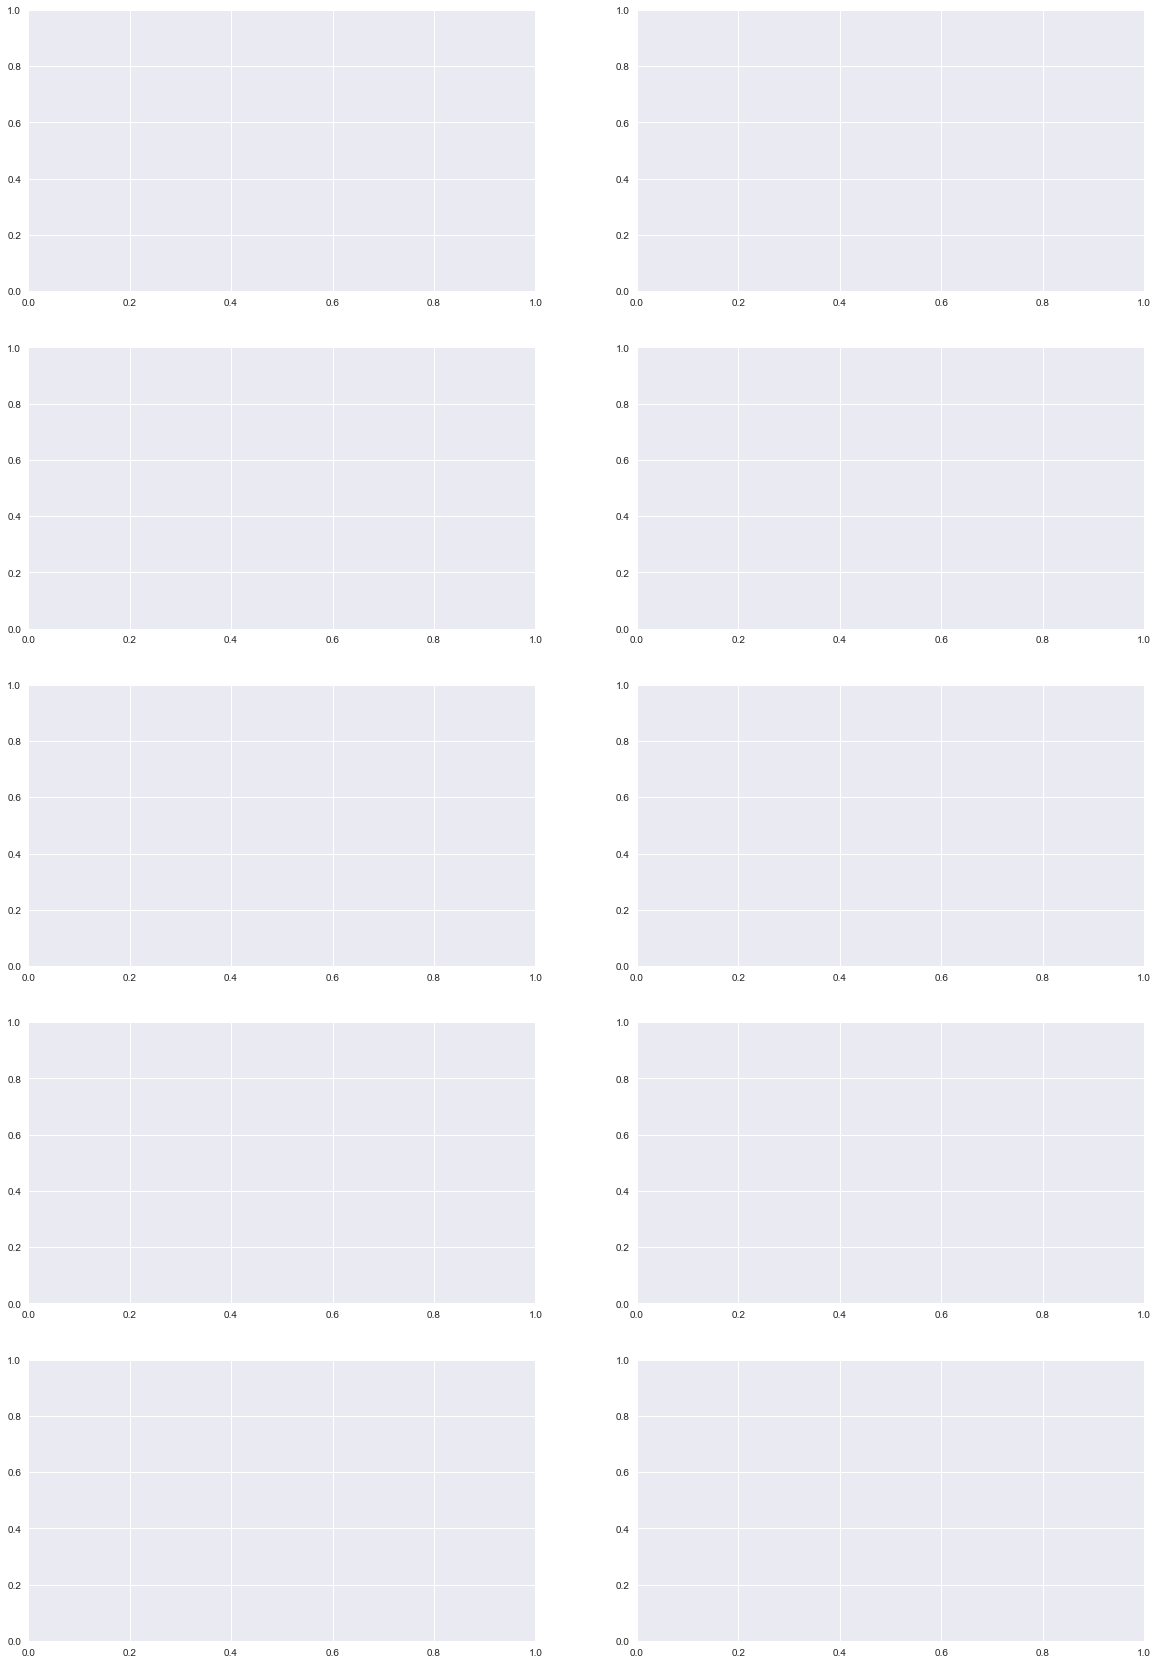

In [16]:
fig1 = plot_mse_and_df_comparison(results_df)
plt.show()

In [17]:
fig = plot_mean_performance(results_df)
plt.show()

NameError: name 'plot_metric_boxplots' is not defined

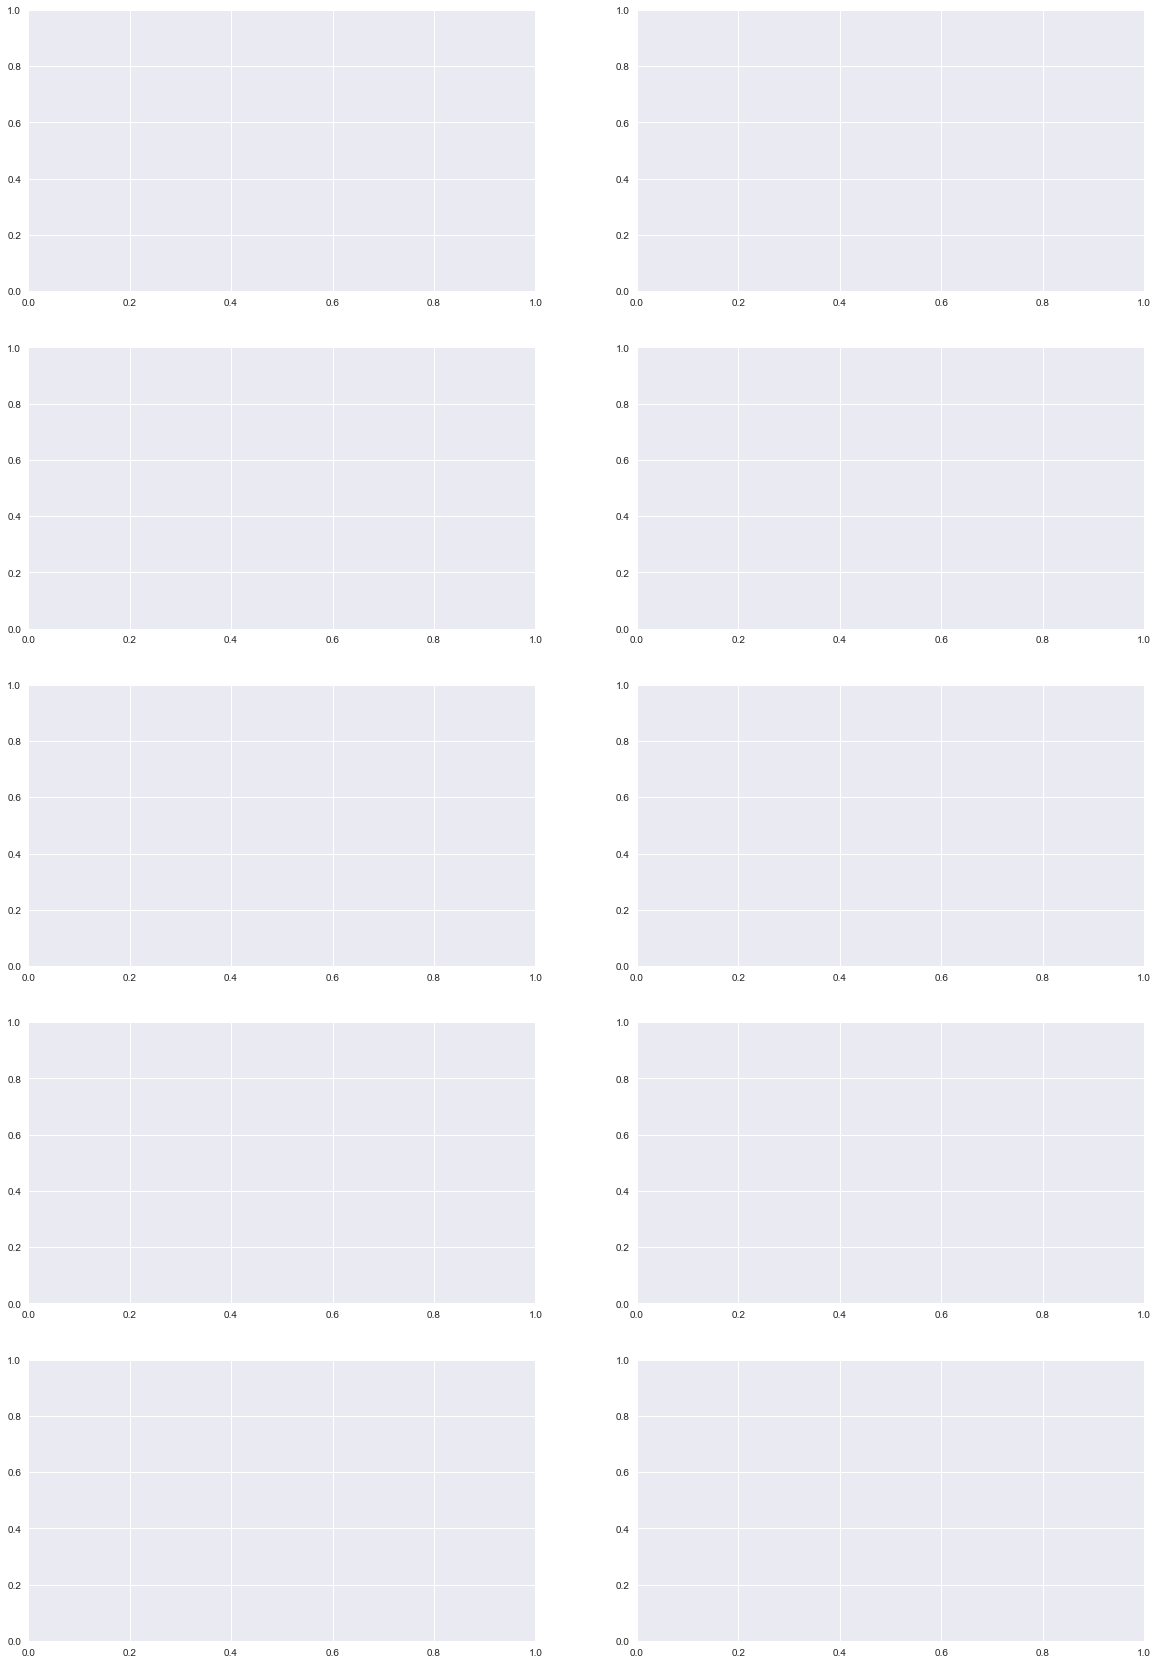

In [18]:
create_all_plots(results_df)

NameError: name 'plot_metric_boxplots' is not defined

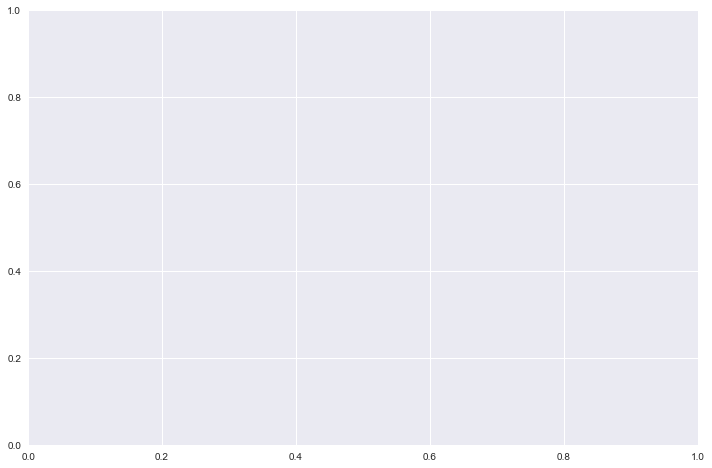

In [19]:
plot_all_comparisons(results_df)

In [ ]:
fig_mse, fig_df = plot_mean_performance_single(results_df)
plt.show()

In [ ]:
fig = plot_k_performance(results_df)
plt.show()

In [ ]:
plot_all_k_performance(results_df)